# Chapter 6. LR Scheduler, Cross-Validation, Metric, Loss, Data Leakage

# 6.1. Import Libraries

In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import os
import shutil

# For neural network
import tensorflow as tf

# For Accuracy metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# For image
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Configs

In [2]:
NUM_FOLDS = 4
EPOCHS = 12
BATCH_SIZE = 200
IMG_SIZE = [128, 128]

# 6.2. Uncompress Data

In [3]:
import zipfile

def unzip(src, dst):
    with zipfile.ZipFile(src, 'r') as zf:
        files = zf.namelist()
        with tqdm(total=len(files), desc='Extracting') as pbar:
            for file in files:
                zf.extract(file, dst)
                pbar.update(1)

                
# Remove old directory
# shutil.rmtree('/kaggle/dogs-vs-cats')


# New directory
os.makedirs('/kaggle/dogs-vs-cats', exist_ok=True)

# Train
unzip('/kaggle/input/dogs-vs-cats/train.zip', '/kaggle/dogs-vs-cats/')

# Test
unzip('/kaggle/input/dogs-vs-cats/test1.zip', '/kaggle/dogs-vs-cats/')

Extracting:   0%|          | 0/25001 [00:00<?, ?it/s]

Extracting:   0%|          | 0/12501 [00:00<?, ?it/s]

In [4]:
!tree /kaggle/dogs-vs-cats -L 1

/kaggle/dogs-vs-cats
├── test1
└── train

2 directories, 0 files


# 6.3. Meta Data
Not all dataset comes with prepared **metadata** (csv file containing file/image/feature/label info). Thus we need to learn how to prepare one for a custom dataset.

## Get Image Paths
First we'll use `glob` to access the file paths of each image to link them to their labels and data split.



In [5]:
paths = glob('/kaggle/dogs-vs-cats/train/*jpg')
print(f"Num Train: {len(paths)}")

test_paths = glob('/kaggle/dogs-vs-cats/test1/*jpg')
print(f"Num Test: {len(test_paths)}")

Num Train: 25000
Num Test: 12500


## Build DataFrame (CSV File)

In [6]:
print('Train:')
df = pd.DataFrame(paths, columns=['image_path'])
display(df.head(2))

print('Test:')
test_df = pd.DataFrame(test_paths, columns=['image_path'])
display(test_df.head(2))

Train:


,image_path
0,/kaggle/dogs-vs-cats/train/dog.890.jpg
1,/kaggle/dogs-vs-cats/train/dog.1178.jpg


Test:


,image_path
0,/kaggle/dogs-vs-cats/test1/10435.jpg
1,/kaggle/dogs-vs-cats/test1/6790.jpg


# 6.4. Sample from Data
To reduce time we've down sampled the data. If you are welcome to run on the full dataset. To do so, simply comment out the cell.

In [7]:
df = df.sample(15000, random_state=42)
test_df = test_df.sample(2000, random_state=42)

# 6.5. Retreive Metadata
In the following cell we'll retreive `train-test` split and `class` infomation from **image path**. 


In [8]:
# First we map the class name from the image paths, similar to how it is done in the above code
# Train
df['class_name'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract class

display(df.head(2))

,image_path,class_name
6868,/kaggle/dogs-vs-cats/train/dog.7293.jpg,dog
24016,/kaggle/dogs-vs-cats/train/dog.1822.jpg,dog


In [9]:
name2label = {k: v for v, k in enumerate(sorted(df['class_name'].unique()))}
name2label

{'cat': 0, 'dog': 1}

In [10]:
label2name = {v: k for k, v in name2label.items()}
label2name

{0: 'cat', 1: 'dog'}

Now we map the class_labels to the number

In [11]:
# transforming the labels
df['class_label'] = df['class_name'].map(name2label)
display(df.head(2))

,image_path,class_name,class_label
6868,/kaggle/dogs-vs-cats/train/dog.7293.jpg,dog,1
24016,/kaggle/dogs-vs-cats/train/dog.1822.jpg,dog,1


## Retreiver `id` column

In [12]:
df['id'] = df.image_path.map(lambda x: x.split('/')[-1].split('.')[1]) # extract id
display(df.head(2))


test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0]) # extract id
display(test_df.head(2))

,image_path,class_name,class_label,id
6868,/kaggle/dogs-vs-cats/train/dog.7293.jpg,dog,1,7293
24016,/kaggle/dogs-vs-cats/train/dog.1822.jpg,dog,1,1822


,image_path,id
1766,/kaggle/dogs-vs-cats/test1/12448.jpg,12448
11919,/kaggle/dogs-vs-cats/test1/229.jpg,229


# 6.6. Data Split

## Proper Validation of Model

**Proper validation of a model is extremely vital**. For instance, let's consider an analogy from the world of education. Achieving a high CGPA from MIT and garnering a high CGPA from a lesser-known institution, XYZ University, cannot be evaluated on the same scale due to their disparate academic rigors and evaluation standards.

Imagine you're studying for a math test. You have a whole book of math problems, but you decide to only practice on a random selection of these problems. After learning, you test yourself on the remaining problems and score really well. But does this high score mean you're actually good at math? Let's think about this a little deeper.

Imagine if, by chance, you randomly picked all the **hard** problems to **learn from** and left all the **easy problems** for **testing**. You've effectively studied the difficult concepts and are now being tested on the simpler ones. This isn't a balanced test of your overall math abilities, is it? 

This same issue can arise in machine learning when we use the `train_test_split` method for model evaluation. This method divides our data into two distinct sets - one set for training our model (like the problems you practiced on), and another for evaluating its performance (like the problems you tested yourself on). However, if we randomly end up training the model on the more difficult or complex data and test it on the simpler data, the evaluation isn't truly comprehensive or fair.

## Cross-Validation

To tackle this problem, we use a technique called **Cross Validation**. This method divides the data into several parts, known as **folds** or **subsets**. Instead of measuring the model's performance just once, we measure it multiple times - as many times as there are folds. Each time, we take one fold for validation and use the rest for training. This way, we ensure the model is evaluated on all subsets of the data, giving us a much more accurate and comprehensive understanding of its performance. It's like testing yourself on all types of math problems - easy, hard, and everything in between - to truly gauge your understanding.

**Animation:**

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif" width="700">

**Diagram:**

<img src="https://codingdisciple.com/images/cross-validation/Kfold.PNG" width="700">


## KFold

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Reset the index
df = df.reset_index(drop=True)

# Create a new column 'fold' with default value -1
df['fold'] = -1

# Create an instance of KFold with 4 splits
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Use KFold to assign each row to a fold
for fold, (train, valid) in enumerate(kf.split(df)):
    df.loc[valid, 'fold'] = fold

print(df.groupby(['fold','class_name'])['id'].size())

fold  class_name
0     cat           1867
      dog           1883
1     cat           1867
      dog           1883
2     cat           1808
      dog           1942
3     cat           1890
      dog           1860
Name: id, dtype: int64


## Visualize Class Dist of KFold

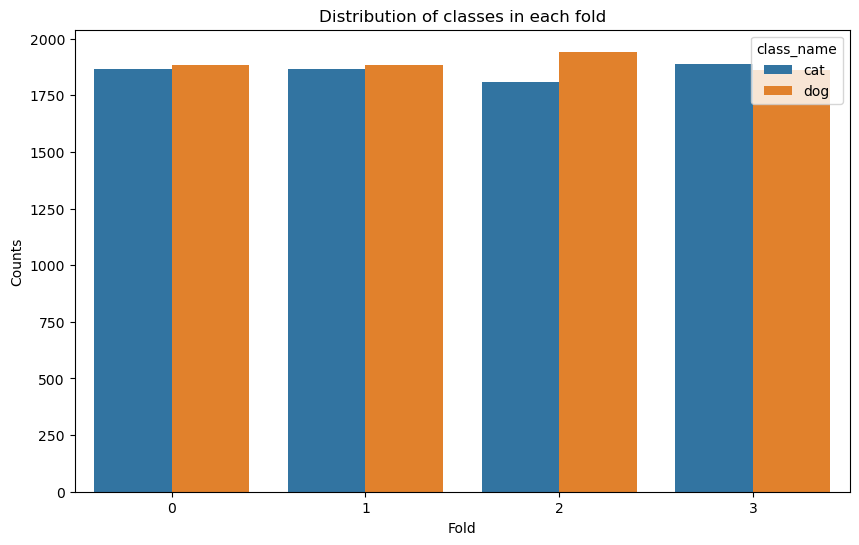

In [14]:
import seaborn as sns

# Create a DataFrame with counts of each class in each fold
class_counts = df.groupby(['fold','class_name'])['id'].size().reset_index(name='counts')

# Create a figure and axis for the plot
plt.figure(figsize=(10,6))

# Create a bar plot
sns.barplot(data=class_counts, x='fold', y='counts', hue='class_name')

# Set plot labels and title
plt.xlabel('Fold')
plt.ylabel('Counts')
plt.title('Distribution of classes in each fold')

# Show the plot
plt.show()

## Different Cross Validation Techniques

| Technique                | Usage                                                                     | Initialization               | Instance Split                             |
|--------------------------|---------------------------------------------------------------------------|------------------------------|-------------------------------------------|
| K-Fold  | Uniform data distribution, unknown data distribution.                     | `kf = KFold(n_splits=5)`     | `kf.split(X)`         |
| Stratified K-Fold        | Imbalanced data where classes have different sample sizes. Ex: Skin Cancer, positive case is only  $1 - 3\%$              | `skf = StratifiedKFold(n_splits=5)` | `skf.split(X, y)` |
| Group K-Fold             | Group-wise data, where all samples related to a group should be together. Ex: X-ray/CT/MRI of a patient| `gkf = GroupKFold(n_splits=2)` | `gkf.split(X, y, groups)` |
| LeaveOneOut              | Small datasets, ensuring a high level of accuracy when estimating model performance. | `loo = LeaveOneOut()` | `loo.split(X)` |
| TimeSeriesSplit          | Time-series data, where temporal order is important. Ex: Stock prices, weather data. Future data is off-limits for training as our task is to predict the future. | `tss = TimeSeriesSplit(n_splits=5)` | `tss.split(X)` |

> **Note**: In the "TimeSeriesSplit" row, it's emphasized that the future data is off-limits for training. This is because in time-series forecasting tasks, the goal is to predict future data, and therefore we should not use future data in the training process as it would cause data leakage.

# 6.7. Data Check

Before diving deeper into the analysis, it's crucial to ensure that our metadata – including path and label – aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.


## Utility

In [15]:
# opencv (cv2) is used for loading image
def load_image(path):
    img = cv2.imread(path, -1) # `-1` means load image as it is, thus no gray to rgb conversion
    img = img[...,::-1] # bgr to rgb
    return img

## One Sample

## Image Shape: (375, 499, 3)
## Label: 1
## Name: dog


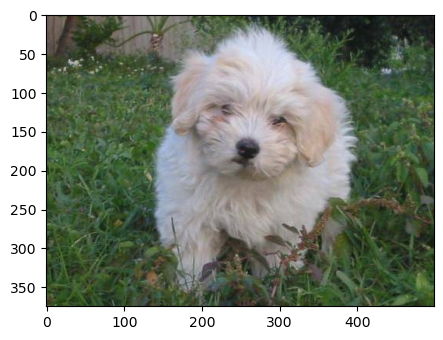

In [16]:
row = df.iloc[20]
img = load_image(row.image_path)
print(f"## Image Shape: {img.shape}")
print(f"## Label: {row.class_label}")
print(f'## Name: {row.class_name}')

plt.figure(figsize=(5,5))
plt.imshow(img);

## Multiple Samples

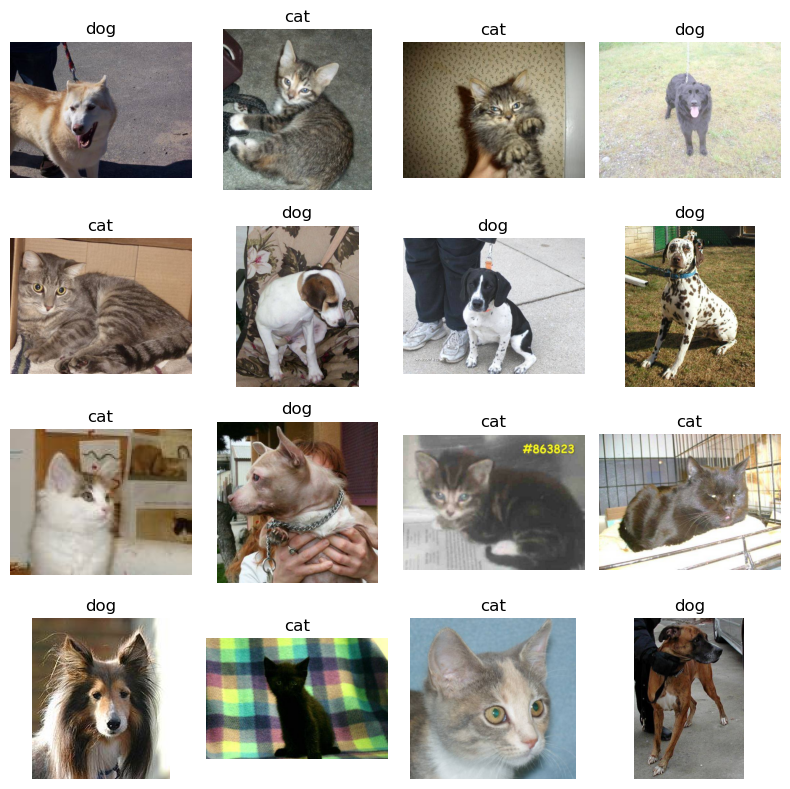

In [17]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(grid_size**2):
    # Generate random index
    img_idx = np.random.randint(0, len(df))
    row = df.iloc[img_idx]
    
    # Load the image using your preferred method (not implemented here)
    img = load_image(row.image_path)

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(str(row.class_name))
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

# 6.8. Data Loader
Processing large datasets that consume a significant amount of memory can be challenging. Thus loading full data on memory is not feasible. By generating and batching datasets using multiple cores in real-time, it becomes possible to seamlessly integrate them with deep learning models.

In [18]:
import albumentations as A

class DataLoader(tf.keras.utils.Sequence):
    """
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        paths (list): List of file paths for the images.
        labels (list): List of corresponding labels for the images. 
                       Set labels= None if you are infering on test dataset (where you dont have labels)
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """

    def __init__(self, paths, labels=None, batch_size=32, num_classes=1,
                 dim=(128, 128), shuffle=True, augment=False, augment_fn=None):
        """Initialization method for the DataLoader class."""
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        
        # For augmentation
        self.augment = augment
        self.augment_fn = augment_fn
        if self.augment and self.augment_fn is None:
            self.augment_fn = A.Compose([A.HorizontalFlip(p=0.5),
                                         A.RandomBrightnessContrast(p=0.5),
                                         A.Rotate(limit=30, p=0.5)])
                                        
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        if self.labels is not None:
            y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load image
            img = load_image(self.paths[idx])
            
            # Resize image as not all images are with same shape
            img = cv2.resize(img, dsize=self.dim)             
            
            # Apply augmentation
            if self.augment:
                img = self.augment_fn(image=img)["image"]
                
            # Store sample
            X[i,] = img

            # Store class
            if self.labels is not None:
                y[i] = self.labels[idx]

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0

        # Apply one-hot encoding to labels [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.labels is not None:
#             y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            y = y.reshape(-1, 1)
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Loader check

In [19]:
paths = df.image_path.tolist()
labels = df.class_label.tolist()

train_loader = DataLoader(paths, labels, batch_size=16, augment=True)

imgs, tars = train_loader.__getitem__(0)
print("Images:\n", imgs.shape)

print("\nLabels:\n", tars.shape)

Images:
 (16, 128, 128, 3)

Labels:
 (16, 1)


## Visualize Loader

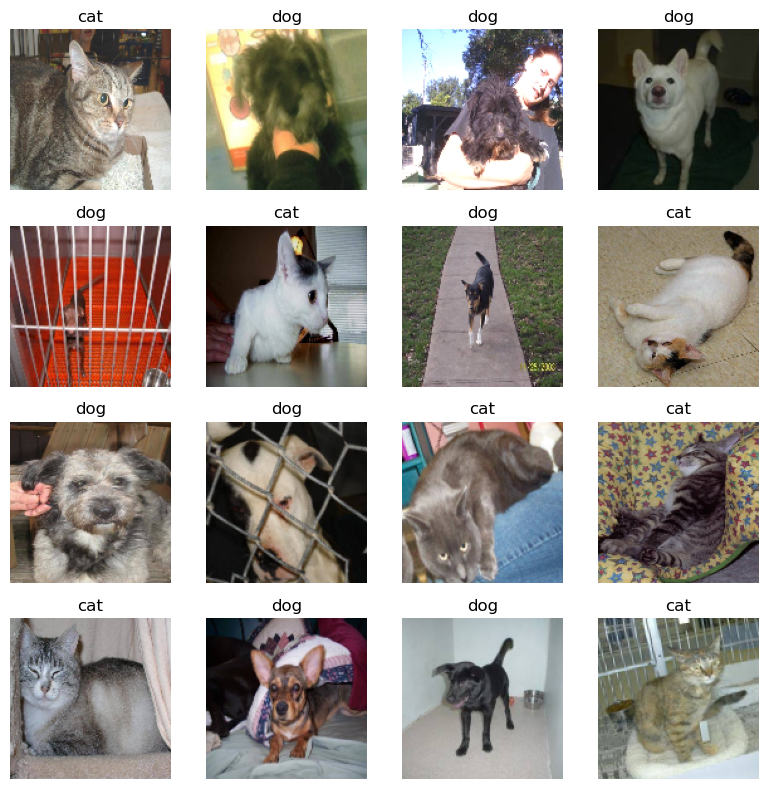

In [20]:
# Define the size of the grid
grid_size = 4

# Create a figure and axes for the grid of images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))

# Iterate over the images and labels
for i in range(16):
    
    # Load the image
    img = imgs[i] # images are feed as flatten to models
    
    # Get Label
    tar = int(tars[i]>0.5) # label is one hot encoded
    name = label2name[tar]

    # Determine the row and column indices in the grid
    x = i // grid_size
    y = i % grid_size

    # Display the image in the corresponding grid cell
    axes[x, y].imshow(img)
    axes[x, y].set_title(name)
    axes[x, y].axis('off')

# Adjust the spacing and layout of the subplots
plt.tight_layout()

# Show the grid of images
plt.show()

## Utils

In [21]:
import matplotlib.pyplot as plt

def plot_history(history, fold=0):
    # summarize history for accuracy
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-o')
    plt.plot(history.history['val_accuracy'], '-o')
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation accuracy is max
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc)
    plt.annotate(f'best: {best_val_acc:.2f} @ {best_val_acc_epoch+1}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title(f'Fold-{fold}: Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation loss is min
    best_val_loss_epoch = best_val_acc_epoch
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.annotate(f'best: {best_val_loss:.2f} @ {best_val_loss_epoch+1}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    plt.tight_layout()
    plt.show()

# 6.11. Metrics

In data analysis, metrics are vital in measuring the performance of our models. Sometimes, we need to create our own metrics for unique tasks that aren't readily available in our library. Fortunately, crafting a custom metric is straightforward – all we need is a function that takes in `y_true` (the actual values) and `y_pred` (the predicted values) and calculates the metric from them. Since metrics are not utilized during training, they don't need to be differentiable.

 Now, we're going to learn how to implement a popular metric known as the `F1 Score`.

![Metrics diagram](https://newbiettn.github.io/images/precision-recall.jpg)

The `F1 Score` is based on two other important metrics: Precision (P) and Recall (R). Here's how they're calculated:

1. **Precision (P):** This is the proportion of correct positive predictions out of total positive predictions. It's calculated as:
   
$$ Precision = \frac{TP}{TP+FP} = \frac{\sum (A * B)}{\sum A} $$

2. **Recall (R):** This is the proportion of correct positive predictions out of total actual positive instances. It's calculated as:
   
$$ Recall = \frac{TP}{TP+FN} = \frac{\sum (A * B)}{\sum B}  $$

3. **F1 Score (F1):** This is the harmonic mean of precision and recall, and it's calculated as:

$$ F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall} $$

Before we continue, let's understand some terms used in these calculations:

- **TP (True Positives):** The number of correct positive predictions.
- **FP (False Positives):** The number of incorrect positive predictions.
- **FN (False Negatives):** The number of incorrect negative predictions.

As you practice more with these concepts, you'll understand their importance and how they affect the performance of your data models.


In [22]:
import numpy as np
from sklearn.metrics import f1_score as sk_f1_score
import tensorflow as tf

# Our custom F1 score function
def f1_score(y_true, y_pred):
    """
    Compute F1 Score, also known as balanced F-score or F-measure

    The F1 score can be interpreted as a weighted average of the precision and recall, 
    where an F1 score reaches its best value at 1 and worst score at 0.
    """
    tp = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    tp_plus_fp = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_pred, 0, 1)))
    tp_plus_fn = tf.math.reduce_sum(tf.math.round(tf.clip_by_value(y_true, 0, 1)))

    precision = tp / (tp_plus_fp + tf.keras.backend.epsilon())
    recall = tp / (tp_plus_fn + tf.keras.backend.epsilon())

    f1_val = 2*(precision*recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

# Generate random predictions and ground truth
y_true = np.random.randint(0, 2, size=(100,))
y_pred = np.random.rand(100,).round()

# Convert numpy arrays to TensorFlow tensors
y_true_tf = tf.constant(y_true, dtype=tf.float32)
y_pred_tf = tf.constant(y_pred, dtype=tf.float32)

# Calculate F1 score using sklearn and our custom function
f1_sklearn = sk_f1_score(y_true, y_pred)
f1_tf = f1_score(y_true_tf, y_pred_tf).numpy()

print("F1 Score (Sklearn): ", f1_sklearn)
print("F1 Score (TensorFlow): ", f1_tf)


F1 Score (Sklearn):  0.45652173913043476
F1 Score (TensorFlow):  0.4565217


# 6.12. Loss Function

Loss functions play a crucial role in the learning process of neural networks and machine learning algorithms. They measure how well a model's predictions align with the actual values and are used to guide the model's optimization process.

To calculate the `Binary Cross-Entropy Loss`, we use the following formula:

$$ BCE = -\frac{1}{N}\sum_{i=1}^{N} [y_i \cdot log(\hat{y_i}) + (1 - y_i) \cdot log(1 - \hat{y_i})] $$

In this formula:

- $N$ is the total number of samples.
- $y_i$ is the true label of the sample (either `0` or `1`).
- $\hat{y_i}$ is the predicted probability of the sample belonging to `class 1`.

> So, in summary, the `Binary Cross-Entropy Loss` function rewards predictions that are close to the true labels and punishes predictions that are far from the true labels. As we train our model, we aim to minimize this loss, bringing our predictions closer and closer to the true labels.

> **Note**: Cost/Loss function needs to differentiable.

In [23]:
def binary_cross_entropy(y_true, y_pred):
    """
    Compute binary cross-entropy loss.

    This function computes the binary cross-entropy loss between true labels and predicted labels. 
    It uses TensorFlow's low-level operations.

    Parameters:
    y_true (tf.Tensor): a tensor of true labels.
    y_pred (tf.Tensor): a tensor of predicted labels.

    Returns:
    tf.Tensor: a tensor representing the binary cross-entropy loss.

    """
    # Clip y_pred between eps and 1-eps to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute binary cross entropy loss
    loss = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    
    # Return mean loss
    return tf.reduce_mean(loss)


# Generate some random predictions and labels
y_true = np.random.randint(0, 2, size=(100,))
y_pred = np.random.random(100,)

# Compute loss using tf.keras.losses.BinaryCrossentropy
loss_tf = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred).numpy()

# Compute loss using our custom function
loss_custom = binary_cross_entropy(y_true, y_pred).numpy()

# Print out the results
print("Loss from built-in function: ", loss_tf)
print("Loss from custom function: ", loss_custom)
print("Are the results identical? ", np.isclose(loss_tf, loss_custom))

Loss from built-in function:  0.9885621472040883
Loss from custom function:  0.9885629939099273
Are the results identical?  True


# 6.13. VGG


**Major Contributions of VGG Network:**

1. **Uniform Architecture:** VGG demonstrated that using small (3x3) convolution filters in a deep network can achieve excellent performance.
2. **Depth Importance:** VGG showed the importance of depth in a network. It included 16-19 layers and outperformed shallower architectures.
3. **Transfer Learning:** VGG models, due to their excellent generalization capabilities, have been widely used for transfer learning.


**Achitecture**

<img src="https://iq.opengenus.org/content/images/2019/01/vgg_layers.png" width="700">

---

**Pros and Cons of VGG Network:**

| Pros | Cons |
|---|---|
| Demonstrated the power of depth in neural networks | Very resource-intensive due to its depth |
| Simple and uniform architecture is easy to understand | Longer training times due to the large number of layers |
| Excellent for transfer learning due to good feature generalization | Requires more memory due to the number of parameters |
| Good performance on object recognition tasks | Overfitting risk due to its complexity and depth |

# 6.14. Pre-trained VGGNet

In [24]:
def VGG16(input_shape=(224, 224, 3),
          num_classes=1,
          lr=0.5e-3,
          num_unfreeze=2):
    # Define input layer
    inp = tf.keras.layers.Input(shape=input_shape)

    # Load pre-trained VGG16 model with imagenet weights
    base_model = tf.keras.applications.VGG16(weights='imagenet',
                                             include_top=False, # drop classifer head
                                             input_shape=input_shape)

    # Freeze or unfreeze the model
    if num_unfreeze is None:
        base_model.trainable = True  # Full fine-tuning
    else:
        base_model.trainable = False  # Freeze all layers by default
        if num_unfreeze > 0:
            # Unfreeze the specified number of layers from the end
            for layer in base_model.layers[-num_unfreeze:]:
                layer.trainable = True

    # Add custom classification layers on top
    x = base_model(inp)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    out = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    # Create the final model
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=binary_cross_entropy,
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), f1_score])
    return model

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
__________________________________________

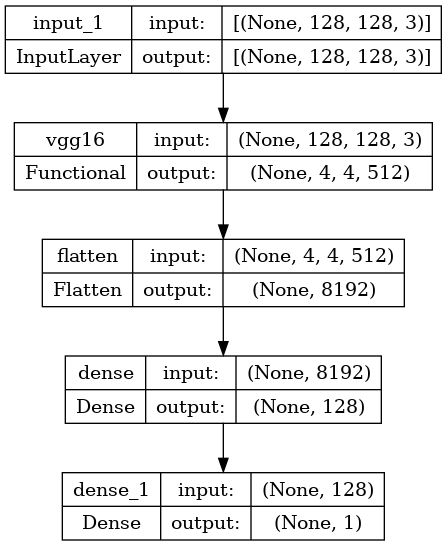

In [25]:
# Use function to create a model
model = VGG16(input_shape=(128, 128, 3), num_classes=1, num_unfreeze=5)
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

# 6.15. Learning Rate Scheduler

Even though adaptive learning rate optimizers (`Adam`, `AdaGrad`) are smart enough to adjust the learning rate for each weight during training, there are still reasons you might want to use a learning rate scheduler. Let's consider these reasons in detail:

1. **Global Learning Rate Control:** Adaptive learning rate optimizers adjust the learning rate for each weight separately based on the gradients. However, there is still a global learning rate hyperparameter that controls the overall scale of these adjustments. Using a learning rate scheduler to reduce this global learning rate over time can be beneficial. As training progresses, the model converges towards a minimum, and making large changes can lead to overshooting. By reducing the global learning rate, we allow the model to make smaller, more refined steps. 

3. **Avoid Overfitting:** A learning rate that's too high for too long can cause the model to overfit, where the model learns the training data too well and performs poorly on unseen data. Reducing the learning rate over time can help to prevent overfitting by slowing down learning and allowing the model to generalize better.

4. **Overcome Plateaus:** During training, the model may reach a plateau where the model performance on the validation set stops improving. Reducing the learning rate can help the model to "jump out" of these plateaus and continue to improve.

> **Summary**: While adaptive optimizers are a powerful tool, they are not a magic bullet that eliminates the need to manage the learning rate. Learning rate schedulers offer an additional layer of control and can help to improve the performance of your model, even when used alongside adaptive learning rate optimizers.

## Different LR Schedulers

* **CosineWarmRestarts**:

<img src="https://user-images.githubusercontent.com/20135989/68026469-cccc5200-fcea-11e9-9399-11e4a5a5eae3.png" width=500>

* **CosineAnnealingLR**:

<img src="https://www.researchgate.net/publication/343341777/figure/fig1/AS:919348742979584@1596201229282/The-cosine-annealing-leaning-rate-in-different-Tmax.png" width=500>

* **ReduceLROnPlateau**:

<img src="https://miro.medium.com/max/1400/1*L6Dq6AgpWwjRNzmJ8EsEVA.png" width=500>

* **ExponentialLR**:

<img src="https://miro.medium.com/max/1400/1*CgioTtU7G7mL202dL7CVfg.png" width=500>

## Build LR Scheduler

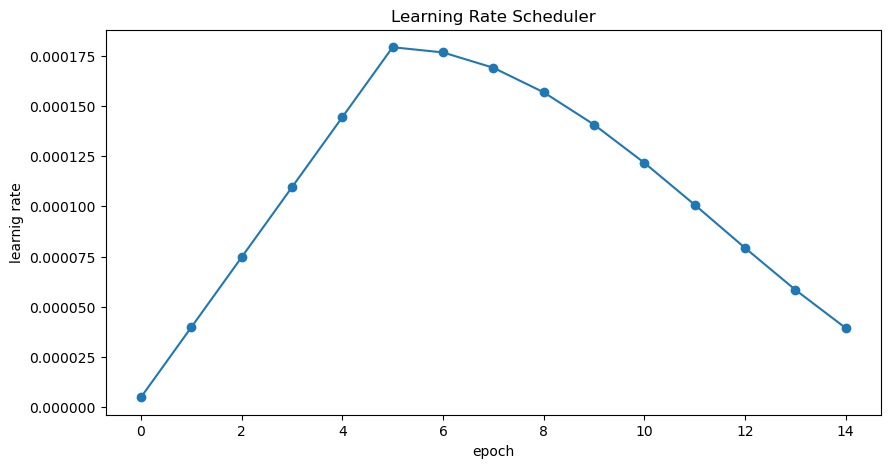

In [26]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=15, plot=False):
    """
    Create a learning rate scheduler callback.
    
    Parameters:
    - batch_size: the batch size during training
    - mode: the learning rate decrease mode ('exp', 'step', 'cos')
    - total_epochs: the total number of epochs during training
    - show_plot: a flag to show the learning rate schedule plot
    
    Returns:
    - a LearningRateScheduler callback
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

lr_cb = get_lr_callback(batch_size=128, plot=True)

# 6.16. Training Model

#################################################################
Fold: 0 | Model: VGGNet | ImgSize: [128, 128] | BatchSize: 200
Num Train: 11250 | Num Valid: 3750
#################################################################
>> Training
Epoch 1/12
57/57 [==============================] - 79s 1s/step - loss: 0.7149 - accuracy: 0.5069 - f1_score: 0.4626 - val_loss: 0.6774 - val_accuracy: 0.5674 - val_f1_score: 0.5469 - lr: 5.0000e-06
Epoch 2/12
57/57 [==============================] - 68s 1s/step - loss: 0.5392 - accuracy: 0.7339 - f1_score: 0.7336 - val_loss: 0.4442 - val_accuracy: 0.8005 - val_f1_score: 0.7964 - lr: 3.9840e-05
Epoch 3/12
57/57 [==============================] - 67s 1s/step - loss: 0.4225 - accuracy: 0.8074 - f1_score: 0.8016 - val_loss: 0.3953 - val_accuracy: 0.8161 - val_f1_score: 0.8278 - lr: 7.4680e-05
Epoch 4/12
57/57 [==============================] - 66s 1s/step - loss: 0.3819 - accuracy: 0.8277 - f1_score: 0.8237 - val_loss: 0.3623 - val_accuracy: 0.8324 - 

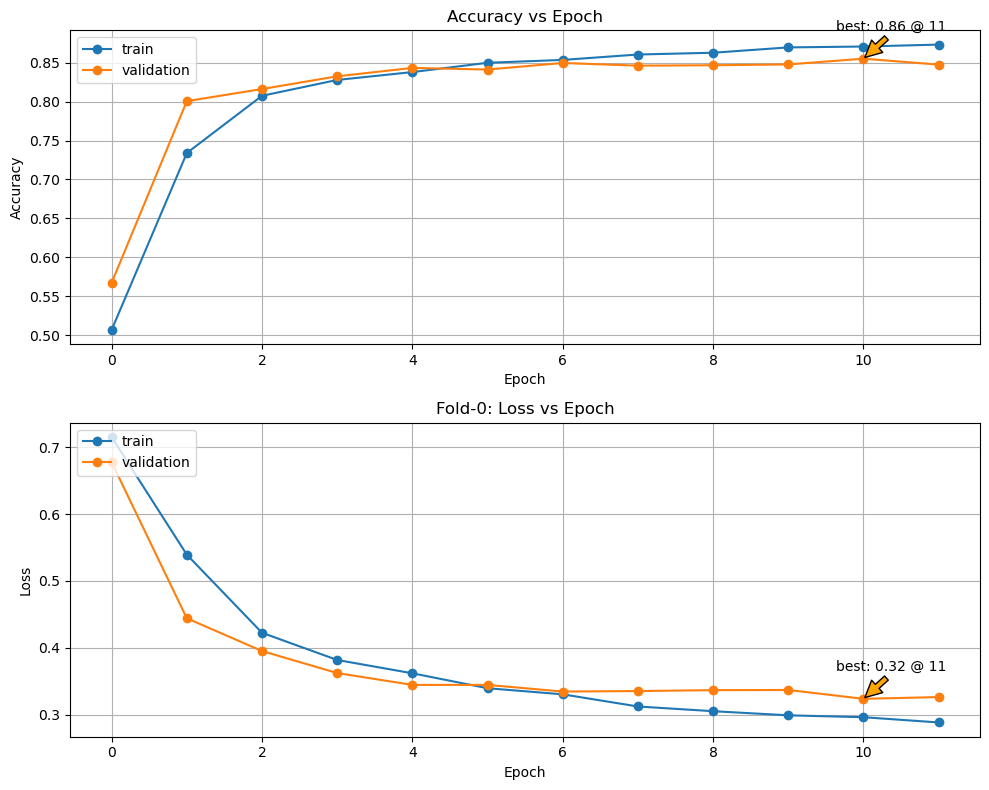

#################################################################
Fold: 1 | Model: VGGNet | ImgSize: [128, 128] | BatchSize: 200
Num Train: 11250 | Num Valid: 3750
#################################################################
>> Training
Epoch 1/12
57/57 [==============================] - 68s 1s/step - loss: 0.6783 - accuracy: 0.5704 - f1_score: 0.5514 - val_loss: 0.6512 - val_accuracy: 0.6305 - val_f1_score: 0.6472 - lr: 5.0000e-06
Epoch 2/12
57/57 [==============================] - 67s 1s/step - loss: 0.5299 - accuracy: 0.7520 - f1_score: 0.7475 - val_loss: 0.4448 - val_accuracy: 0.8013 - val_f1_score: 0.8011 - lr: 3.9840e-05
Epoch 3/12
57/57 [==============================] - 65s 1s/step - loss: 0.4160 - accuracy: 0.8064 - f1_score: 0.8021 - val_loss: 0.3812 - val_accuracy: 0.8266 - val_f1_score: 0.8320 - lr: 7.4680e-05
Epoch 4/12
57/57 [==============================] - 66s 1s/step - loss: 0.3787 - accuracy: 0.8226 - f1_score: 0.8244 - val_loss: 0.3712 - val_accuracy: 0.8384 - 

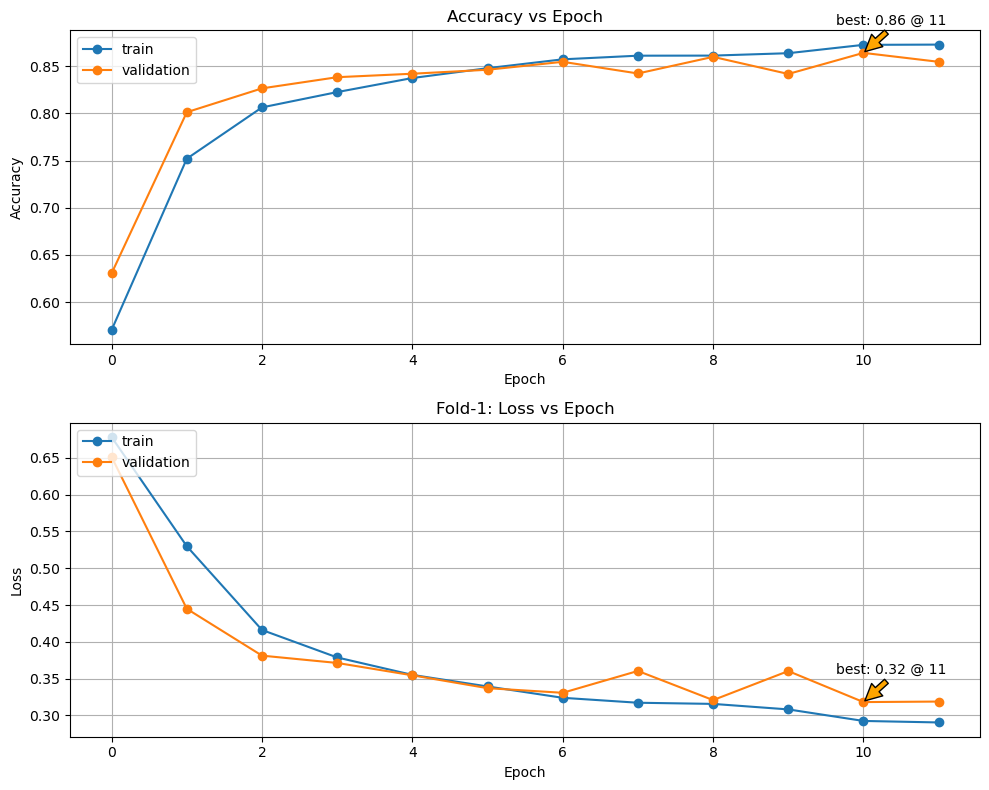

#################################################################
Fold: 2 | Model: VGGNet | ImgSize: [128, 128] | BatchSize: 200
Num Train: 11250 | Num Valid: 3750
#################################################################
>> Training
Epoch 1/12
57/57 [==============================] - 69s 1s/step - loss: 0.7106 - accuracy: 0.5260 - f1_score: 0.4487 - val_loss: 0.6713 - val_accuracy: 0.5879 - val_f1_score: 0.5810 - lr: 5.0000e-06
Epoch 2/12
57/57 [==============================] - 66s 1s/step - loss: 0.5473 - accuracy: 0.7365 - f1_score: 0.7284 - val_loss: 0.4508 - val_accuracy: 0.8032 - val_f1_score: 0.8071 - lr: 3.9840e-05
Epoch 3/12
57/57 [==============================] - 67s 1s/step - loss: 0.4272 - accuracy: 0.8065 - f1_score: 0.7991 - val_loss: 0.3810 - val_accuracy: 0.8279 - val_f1_score: 0.8298 - lr: 7.4680e-05
Epoch 4/12
57/57 [==============================] - 67s 1s/step - loss: 0.3813 - accuracy: 0.8261 - f1_score: 0.8242 - val_loss: 0.3574 - val_accuracy: 0.8408 - 

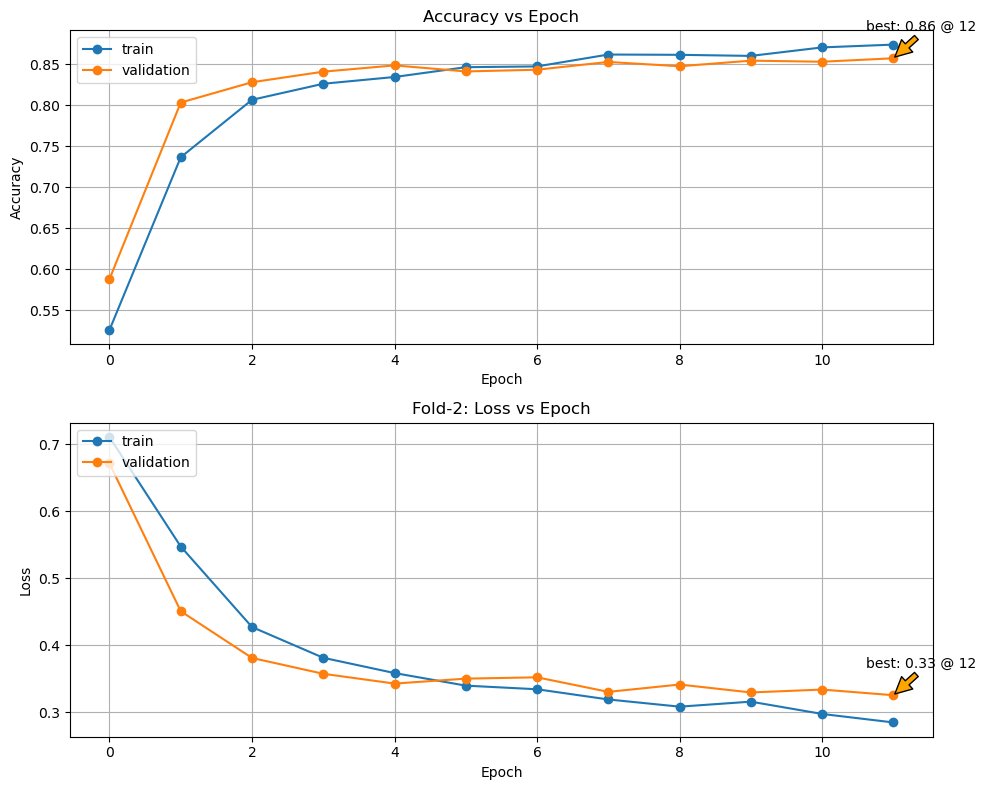

#################################################################
Fold: 3 | Model: VGGNet | ImgSize: [128, 128] | BatchSize: 200
Num Train: 11250 | Num Valid: 3750
#################################################################
>> Training
Epoch 1/12
57/57 [==============================] - 68s 1s/step - loss: 0.7047 - accuracy: 0.5462 - f1_score: 0.4820 - val_loss: 0.6571 - val_accuracy: 0.6132 - val_f1_score: 0.6212 - lr: 5.0000e-06
Epoch 2/12
57/57 [==============================] - 66s 1s/step - loss: 0.5478 - accuracy: 0.7297 - f1_score: 0.7291 - val_loss: 0.4575 - val_accuracy: 0.7887 - val_f1_score: 0.7997 - lr: 3.9840e-05
Epoch 3/12
57/57 [==============================] - 67s 1s/step - loss: 0.4281 - accuracy: 0.8060 - f1_score: 0.8020 - val_loss: 0.3828 - val_accuracy: 0.8287 - val_f1_score: 0.8311 - lr: 7.4680e-05
Epoch 4/12
57/57 [==============================] - 65s 1s/step - loss: 0.3803 - accuracy: 0.8301 - f1_score: 0.8324 - val_loss: 0.3645 - val_accuracy: 0.8366 - 

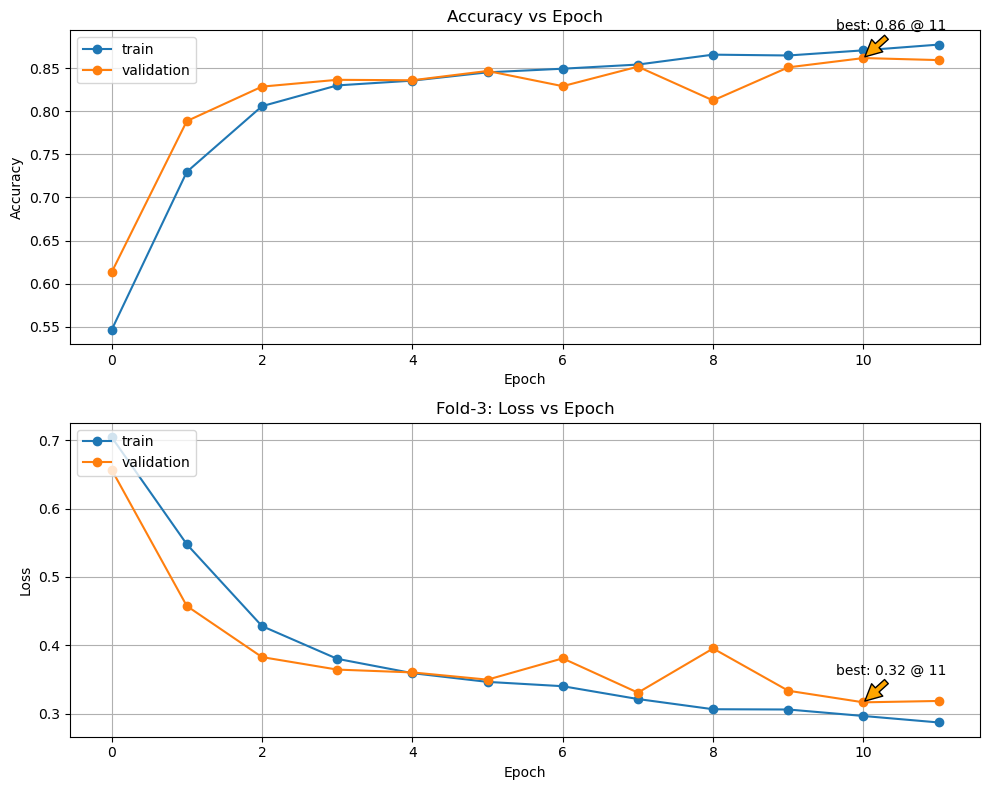


                     Cross Validation Score
|  Mean Fold Score: 0.8600 |  Out-of-Fold Score: 0.8600 | 
---------------------------------------------------------


In [27]:
# Initialize a list to store the accuracy score from each fold
fold_scores = []

# Initialize lists to store the out-of-fold predictions and labels
oof_preds = []
oof_labels = []

# Loop through each fold
for fold in range(NUM_FOLDS):
    
    # Print a message indicating the current fold, the model being used, the image size, and the batch size
    print(f"{'#'*65}\nFold: {fold} | Model: VGGNet | ImgSize: {IMG_SIZE} | BatchSize: {BATCH_SIZE}")

    # Select train and valid fold
    valid_df = df[df.fold==fold]
    train_df = df[df.fold!=fold]
    
    # Step 1: Get the image paths and corresponding labels
    train_paths = train_df['image_path'].tolist()
    train_labels = train_df['class_label'].tolist()

    valid_paths = valid_df['image_path'].tolist()
    valid_labels = valid_df['class_label'].tolist()
    
    print(f"Num Train: {len(train_paths)} | Num Valid: {len(valid_paths)}\n{'#'*65}")

    # Step 2: Load the data
    train_loader = DataLoader(train_paths, train_labels, dim=IMG_SIZE, 
                              batch_size=BATCH_SIZE, augment=True)
    valid_loader = DataLoader(valid_paths, valid_labels, dim=IMG_SIZE,
                              batch_size=BATCH_SIZE, shuffle=False)

    # Step 3: Build the model
    model = VGG16(input_shape=(*IMG_SIZE, 3), num_classes=1, lr=0.3e-3, num_unfreeze=5)
    
    # Step 4: Build Callbacks
    ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = f'/kaggle/working/vgg_fold{fold}.h5',
                                                 monitor = 'val_accuracy',
                                                 verbose = 0,
                                                 save_best_only = True,
                                                 save_weights_only = False,
                                                 mode = 'max')
    lr_cb = get_lr_callback(batch_size=128)

    # Step 4: Train the model
    print('>> Training')
    history = model.fit(train_loader,
                        validation_data=valid_loader,
                        epochs=EPOCHS,
                        verbose=1,
                        callbacks=[ckpt_cb, lr_cb]) # to save best scoring model

    # Step 5: Use the trained model to make predictions on the validation data
    print("\n>> Inference")
    valid_loader = DataLoader(valid_paths, valid_labels, batch_size=160, shuffle=False)
    preds = model.predict(valid_loader)[:len(valid_df)]

    # Convert the predictions to binary labels and store them for the out-of-fold score
    oof_preds.extend((preds > 0.5).astype(int))
    oof_labels.extend(valid_labels)

    # Step 6: Calculate the accuracy of the predictions and store it for the mean fold score
    acc = accuracy_score(valid_labels, (preds>0.5).astype(int))
    fold_scores.append(acc)
    print(f"\n>> Accuracy: {acc}")
    
    ## Plot history of epochs
    plot_history(history, fold)

# Compute the mean fold score
mf_score = np.mean(fold_scores)

# Compute the out-of-fold score
oof_score = accuracy_score(oof_labels, oof_preds)

# Display the scores
print("\n","="*57, sep='')
print(" "*20, "Cross Validation Score")
print("="*57, sep='')
print(f"{'|':^2} Mean Fold Score: {mf_score:.4f} {'|':^2} Out-of-Fold Score: {oof_score:.4f} {'|':^2}")
print("-"*57)


# 6.17 Data Leakage: A Hidden Pitfall

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/data-leakage-in-machine-learning.png" width="500">

Imagine this scenario: You've spent countless hours building your machine learning model. The accuracy of your model on your test set is impressive! You're thrilled, and you can't wait to show off your results... until you deploy your model in the real world, and it performs abysmally. You're flabbergasted, asking yourself, "What just happened?"

Chances are, you've fallen victim to **Data Leakage**.

<img src="https://media.tenor.com/FSEk_JJE4U0AAAAC/kuch-to-gadbad-hai-daya-acp-pradyuman.gif">

## What is Data Leakage?

Data leakage is one of the most insidious issues that can plague machine learning models, and it occurs when your model has access to information during training that it shouldn't have. This can lead to overly optimistic performance measures during the training phase, but poor performance in real-world scenarios. 

In essence, data leakage causes your model to cheat, making it believe it's performing exceptionally well when, in reality, it's merely memorizing the answers.

## How Does Data Leakage Affect Scores?

Data leakage can drastically inflate your model's performance metrics, giving you a false sense of confidence in its predictive power. While you might see stellar performance on your validation and test sets, these measures are likely inaccurate reflections of how your model would perform on unseen, real-world data.

The higher-than-expected performance scores can lead you to overestimate your model's capabilities, which can be disastrous when your model is applied in real-world scenarios and underperforms.

## How to Spot Data Leakage?

Detecting data leakage can be challenging, but here are some red flags to look out for:

1. **Exceptional Performance**: If your model's performance appears too good to be true, it probably is. Excessive accuracy, recall, precision, or other performance measures could indicate data leakage.

2. **Discrepancy Between Training and Real-World Performance**: If there's a considerable gap between how your model performs during training and how it performs on real-world data, you might be dealing with data leakage.

3. **Feature Importance Analysis**: If features that shouldn't logically contribute significantly to your target variable are rated as important, there may be leakage. For instance, an ID column having high predictive power.

4. **Understanding your Data and Pipeline**: Data leakage often occurs due to mistakes in data preparation. For instance, including future information in your features, or normalizing your entire dataset before splitting into training and test sets.

5. **Overlap between Train and Test Sets**: Particularly in medical tasks, multiple samples might come from the same patients. If we place these in both training and test sets, we inadvertently create a leakage situation. Essentially, we're leaking patient information across the sets, which is unrealistic as we won't have prior access to patient information during real-life testing. To mitigate this issue, techniques like `GroupKFold` or `GroupStratifiedKFold` can be used. These methods ensure that data from the same group or patient are only present in either the training or test fold, hence preventing data leakage.
